Before running following codes, please make sure that you have already uploaded the data of interest (including images of interest and shape_predictor_68_face_landmarks.dat) to your own Google drive, and that you change to the correct depository where the images reside by editing cd 'path_for_image'.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/MyDrive/581final"

/content/drive/MyDrive/581final


In [ ]:
import cv2
import dlib
import numpy as np
import sys
import matplotlib.pyplot as plt

In [ ]:
def get_img_gray(source, des):
  source_g = cv2.cvtColor(source, cv2.COLOR_BGR2GRAY)
  des_g = cv2.cvtColor(des, cv2.COLOR_BGR2GRAY)
  return source_g, des_g

def get_model(predictor_path):
  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor(predictor_path)
  return detector, predictor

In [ ]:
def get_index_triangle(points,triangles):
    indexes_triangles = []
    for t in triangles:
        side1 = (t[0], t[1])
        side2 = (t[2], t[3])
        side3 = (t[4], t[5])

        point_indices = []
        for i in range(0, len(points)):
            # if the convex hull points and the triangle points are close enough, 
            # add the indices to the list of triangles
            if abs(side1[0] - points[i][0]) + abs(side1[1] - points[i][1]) <= 2:
                point_indices.append(i)
            if abs(side2[0] - points[i][0]) + abs(side2[1] - points[i][1]) <= 2:
                point_indices.append(i)
            if abs(side3[0] - points[i][0]) + abs(side3[1] - points[i][1]) <= 2:
                point_indices.append(i)

            indexes_triangles.append(point_indices)

    return indexes_triangles

In [ ]:
def process_source_img(img_gray):
    mask = np.zeros_like(img_gray)
    total_graphs = detector(img_gray)  
    for face in total_graphs:
        landmarks = predictor(img_gray, face)
        landmarks_points = []

        #dlib library will return 68 points, stored as landmarks 
        for n in range(0, 68):
            landmarks_points.append((landmarks.part(n).x, landmarks.part(n).y))

        points = np.array(landmarks_points, np.int32)
        convexhull = cv2.convexHull(points)
        cv2.fillConvexPoly(mask, convexhull, 255)

        # do Delaunay triangulation only on the source img
        # than link the corresponding points in destination img
        rect = cv2.boundingRect(convexhull)
        subdiv = cv2.Subdiv2D(rect)
        subdiv.insert(landmarks_points)
        triangles = np.array(subdiv.getTriangleList(), dtype=np.int32)
        indexes_triangles = get_index_triangle(points, triangles)

    #show triangulation:
    # show_triangles(triangles, source)
    
    return landmarks_points, indexes_triangles


def process_replace_img(img_gray):
    total_graphs2 = detector(img_gray)
    for face in total_graphs2:
        landmarks = predictor(img_gray, face)
        landmarks_points2 = []
        for n in range(0, 68):
            landmarks_points2.append((landmarks.part(n).x,landmarks.part(n).y))
        #convert landmark_points to integer for convexHull function
        points2 = np.array(landmarks_points2, np.int32)
        
    return landmarks_points2, cv2.convexHull(points2)

In [ ]:
def show_triangles(triangles, img):
  img_show = img.copy()
  for t in triangles:
    pt1 = (t[0], t[1])
    pt2 = (t[2], t[3])
    pt3 = (t[4], t[5])
    cv2.line(img_show, pt1, pt2, (255, 255, 255), 1)
    cv2.line(img_show, pt2, pt3, (255, 255, 255), 1)
    cv2.line(img_show, pt1, pt3, (255, 255, 255), 1)
  show_rgb(img_show)

In [ ]:
def triangle2points(landmarks_points,triangle_index):
    #use the triangle index to get the triangle points 
    triangle_pt1 = landmarks_points[triangle_index[0]]
    triangle_pt2 = landmarks_points[triangle_index[1]]
    triangle_pt3 = landmarks_points[triangle_index[2]]
    triangle = []
    triangle.append(triangle_pt1)
    triangle.append(triangle_pt2)
    triangle.append(triangle_pt3)
    triangle = np.array(triangle, np.int32)

    # subtract the x and y seperately to get points with offset
    (x, y, size_1, size_2) = cv2.boundingRect(triangle)
    offset_points = []
    offset_points.append([triangle_pt1[0] - x, triangle_pt1[1] - y])
    offset_points.append([triangle_pt2[0] - x, triangle_pt2[1] - y])
    offset_points.append([triangle_pt3[0] - x, triangle_pt3[1] - y])
    points = np.array(offset_points, np.int32)

    return triangle, points

In [ ]:
def affine_triangle(points, points2, triangle2, cropped_triangle):
  (x, y, size_1, size_2) = cv2.boundingRect(triangle2)
  tr2_mask = np.zeros((size_2, size_1), np.uint8)
  cv2.fillConvexPoly(tr2_mask, points2, 255)

  affine_transform = cv2.getAffineTransform(np.float32(points), np.float32(points2))
  warped_triangle = cv2.warpAffine(cropped_triangle, affine_transform, (size_1, size_2))
  warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=tr2_mask)

  return warped_triangle

In [ ]:
def triangulation(indexes_triangles, landmarks_points, landmarks_points2):
    img2_new_face = np.zeros_like(des)

    for triangle_index in indexes_triangles:
        triangle1, points = triangle2points(landmarks_points,triangle_index)
        (x, y, size_1, size_2) = cv2.boundingRect(triangle1)
        cropped_triangle = source[y: y + size_2, x: x + size_1]

        triangle2, points2 = triangle2points(landmarks_points2,triangle_index)
        (x, y, size_1, size_2) = cv2.boundingRect(triangle2)

        # similar to project 5, get affine transform and warp triangles to warp the image 
        warped_triangle = affine_triangle(points, points2, triangle2, cropped_triangle)

        # cut and paste to rebuild the destination face
        rect = img2_new_face[y: y + size_2, x: x + size_1]
        rect_g = cv2.cvtColor(rect, cv2.COLOR_BGR2GRAY)

        _, mask1= cv2.threshold(rect_g, 1, 255, cv2.THRESH_BINARY_INV) 
        rect = cv2.add(rect, cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask1))
        img2_new_face[y: y + size_2, x: x + size_1] = rect
        # show_rgb(img2_new_face)
    
    return img2_new_face

In [ ]:
def get_mask(des_gray, convexhull2):
  mask1 = np.zeros_like(des_gray)
  mask2 = cv2.fillConvexPoly(mask1, convexhull2, 255)
  # plt.imshow(mask1)
  # plt.show()
  # plt.imshow(cv2.bitwise_not(mask1))
  # plt.show()
  return cv2.bitwise_not(mask1), mask2

In [ ]:
def swap_face(des_gray, convexhull2, img2_new_face, des):
    # compute masks use convex function
    face_mask, head_mask = get_mask(des_gray, convexhull2)
  
    noface = cv2.bitwise_and(des, des, mask=face_mask)
    # show_rgb(noface)
    result = cv2.add(noface, img2_new_face)
    # show_rgb(result)

    # Seamless Cloning
    (x, y, size_1, size_2) = cv2.boundingRect(convexhull2)
    center = (int(x + (size_1) / 2), int(y + (size_2) / 2))
    
    return cv2.seamlessClone(result, des, head_mask, center, cv2.MIXED_CLONE)

In [ ]:
def show_landmarks(ld_points, img):
  # print(landmark_points)
  img_show = img.copy()
  for (x,y) in ld_points:
    cv2.circle(img_show, (x,y), radius=0, color=(255, 255, 255), thickness=2)
  show_rgb(img_show)


In [ ]:
def show_rgb(img):
  #cv2 using plt.show will raise error and we need to rearrange rgb layer's order
  b,g,r = cv2.split(img)           # get b, g, r
  rgb_img = cv2.merge([r,g,b]) 
  plt.imshow(rgb_img)
  plt.show()

Source:


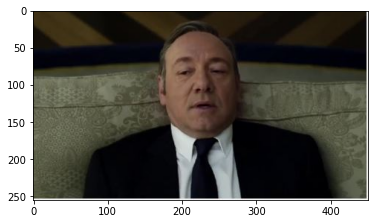

Replace:


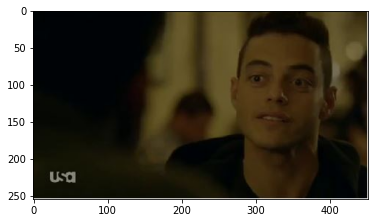

After swapping:


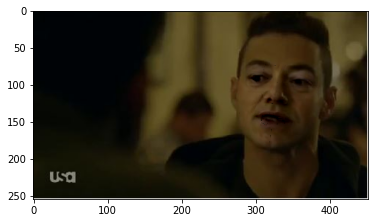

In [ ]:
#####################################################################################
# MAIN 
#####################################################################################
source = cv2.imread("source.JPG") # source image
des = cv2.imread("replace.JPG") # replace image

source_g, des_g = get_img_gray(source, des)
detector, predictor = get_model("shape_predictor_68_face_landmarks.dat") # predictor model path

landmarks_points, indexes_triangles = process_source_img(source_g)
landmarks_points2, convexhull2 = process_replace_img(des_g)
#show feature detection results
# show_landmarks(landmarks_points, source)
# show_landmarks(landmarks_points2, des)

img2_new_face = triangulation(indexes_triangles, landmarks_points, landmarks_points2)
# show_rgb(img2_new_face)
seamlessclone = swap_face(des_g, convexhull2, img2_new_face, des)

print("Source:")
show_rgb(source)
print("Replace:")
show_rgb(des)
print("After swapping:")
show_rgb(seamlessclone)